# Project 3 - Classifying data from the MAGIC Gamma Ray Telescope with Machine Learning Ensemble Methods (Bagging, Random Forests, Boosted Decision Trees)


## Introduction

Note: This project is a follow up to "Project 1 - Classifying MAGIC data by hand" and "Project 2 - Classifying MAGIC data with Decision Trees". 

We will again access data from the MAGIC telescope and anayze it in order to better classify observed particles as being either gamma rays (signal) or neutrons (background). In Project 3 we will again utilize Machine Learning to improve our classification.
   
MAGIC data is currently hosted at the [UC Irvine Machine Learning Repository](https://archive.ics.uci.fAsymedu/ml/datasets/MAGIC+Gamma+Telescope).
  
The repository also contains a description of data and variables [here](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names). For more information please read:
1. [Bock, R.k., et al. "Methods for multidimensional event classification: a case study using images from
a Cherenkov gamma-ray telescope"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.135.6914&rep=rep1&type=pdf)
2. [Fegan, D. "Gamma/Hadron seperation at TeV Energies"](http://iopscience.iop.org/article/10.1088/0954-3899/23/9/004/pdf)

As defined in the references above, the important variables which will be used to classify shower images are based on the characteristics of a typical elliptical shower shape:


    1. fLength:  continuous  # major axis of ellipse [mm]
    2. fWidth:   continuous  # minor axis of ellipse [mm] 
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
    10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
    11.  class:    g,h         # gamma (signal), hadron (background)


<img src="https://github.com/jdolen/PurdueNorthwest_PHYS308_ScientificComputing1/raw/master/Images/MAGIClight.jpg" alt="Drawing" style="width: 600px;"/>

<img src="https://raw.githubusercontent.com/jdolen/PurdueNorthwest_PHYS308_ScientificComputing1/master/Images/MAGICshowerShape.png" alt="Drawing"  width="600"/>

The data provided has already been classified. This will allow us to test how succesful we are at classifying the data using only the shower shape variables. The data is labeled using the following classifications:

   - g = gamma (signal):     12332 events
   - h = hadron (background): 6688 events


## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
import seaborn as sns
from scipy import stats, integrate

Reference: 

[Scikit-Learn Ensemble Methods Learning Guide](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

Links to Common tools:

[Scikit-Learn Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

[Scikit-Learn Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)


[Scikit-Learn Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


[Scikit-Learn Extra Trees Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)


[Scikit-Learn AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

[Scikit-Learn Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics

In [ ]:
# If you are using Google Colab the following imports should just work
# If you are using Jupyter on your home computer you will have to install some fancy tools to visualize your BDT
# To install with conda, from your terminal run:
#  conda install -c conda-forge mlxtend 
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [ ]:
# Data from MAGIC Gamma Ray Telescope 
#   (Major Atmospheric Gamma Imaging Cherenkov Telescopes)
#
# Data hosted by UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/index.php):
#  https://archive.ics.uci.fAsymedu/ml/datasets/MAGIC+Gamma+Telescope
#
# Infromation on data and variables:
#  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
#  
# Paper with some details on the data
#  http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.135.6914&rep=rep1&type=pdf
#
# Paper describing variable definitions in more detail:
#  http://iopscience.iop.org/article/10.1088/0954-3899/23/9/004/pdf
#
# Important variables:
#    1.  fLength:  continuous  # major axis of ellipse [mm]
#    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
#    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
#    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
#    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
#    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
#    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
#    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
#    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
#   10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
#   11.  class:    g,h         # gamma (signal), hadron (background)

# Class Distribution:
#
#   g = gamma (signal):     12332
#   h = hadron (background): 6688


data_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data'
#data_path = 'magic04.data'
variable_names =['fLength',   'fWidth',  'fSize', 'fConc','fConc1', 'fAsym', 
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

df = pd.read_csv(data_path, names=variable_names, na_values='?')

# Add a gamma boolean column
df.loc[df['class'] == 'g', 'isGamma'] = True
df.loc[df['class'] == 'h', 'isGamma'] = False

# Add a hadron boolean column
df.loc[df['class'] == 'h', 'isHadron'] = True
df.loc[df['class'] == 'g', 'isHadron'] = False

# Create a new data frame with just gammas
df_gammas  = df[df['isGamma'] == True]

# Create a new data frame with just hadrons
df_hadrons = df[df['isHadron'] == True]

# Divide up the data into training and testing datasets
df_gammas_train  = df_gammas.iloc[0:2000]
df_gammas_test   = df_gammas.iloc[2000:]
df_hadrons_train = df_hadrons.iloc[0:2000]
df_hadrons_test  = df_hadrons.iloc[2000:]

# Define also a small test sample for plotting purposes 
df_gammas_test_small   = df_gammas.iloc[2000:2400]
df_hadrons_test_small  = df_hadrons.iloc[2000:2400]

# put the training datasets back together
df_all_train      = pd.concat([df_gammas_train,df_hadrons_train],axis=0)
df_all_test       = pd.concat([df_gammas_test,df_hadrons_test],axis=0)
df_all_test_small = pd.concat([df_gammas_test_small,df_hadrons_test_small],axis=0)

# Define the "isGamma" column to be the column which is used to define signal events and background events
df_all_train["isGamma"]      = df_all_train["isGamma"].astype('category')
df_all_test["isGamma"]       = df_all_test["isGamma"].astype('category')
df_all_test_small["isGamma"] = df_all_test_small["isGamma"].astype('category')

In [ ]:
df_all_test

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,isGamma,isHadron
2000,42.6022,16.2177,2.6542,0.2794,0.1408,5.8280,-20.4591,7.5307,9.8372,217.4340,g,True,False
2001,20.2427,6.8375,2.1569,0.7944,0.4634,19.6570,15.0587,-5.3686,22.9125,169.2650,g,True,False
2002,37.2558,17.8501,2.7226,0.3371,0.1790,18.8022,37.3022,13.4788,14.8817,155.7990,g,True,False
2003,61.2538,48.2495,3.5864,0.1128,0.0693,43.2478,45.3327,37.8267,14.4978,93.0088,g,True,False
2004,46.5503,21.7313,2.6410,0.3131,0.1726,56.6296,42.9528,21.9683,18.7204,245.7970,g,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h,False,True
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h,False,True
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h,False,True
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h,False,True


## Example 1: Train and visualize multiple ensemble classifiers using only two features

In [ ]:
# Create a pandas series for each of the two variables
series_train_fLength        = df_all_train['fLength']
series_train_fAlpha         = df_all_train['fAlpha']

# Create a pandas dataframe containing just these two variables
df_train_fLength_fAlpha = pd.DataFrame(dict(fLength=series_train_fLength, fAlpha=series_train_fAlpha))

# Create a 2D numpy array from this dataframe
X_train_fLength_fAlpha  = df_train_fLength_fAlpha .to_numpy(dtype='float')

# Create a 1D numpy array containing the "truth" information 
y_train = df_all_train["isGamma"].cat.codes.to_numpy(dtype='int')

In [ ]:
# Repeat this process using the testing datasets

# Create a pandas series for each of the two variables
series_test_fAlpha          = df_all_test['fAlpha']
series_test_fLength         = df_all_test['fLength']
series_test_small_fAlpha    = df_all_test_small['fAlpha']
series_test_small_fLength   = df_all_test_small['fLength']

# Create a pandas dataframe containing just these two variables
df_test_fLength_fAlpha       = pd.DataFrame(dict(fLength=series_test_fLength, fALpha=series_test_fAlpha))
df_test_fLength_fAlpha_small = pd.DataFrame(dict(fLength=series_test_small_fLength, fALpha=series_test_small_fAlpha))

# Create a 2D numpy array from this dataframe
X_test_fLength_fAlpha       = df_test_fLength_fAlpha.to_numpy(dtype='float')
X_test_fLength_fAlpha_small = df_test_fLength_fAlpha_small.to_numpy(dtype='float')

# Create a 1D numpy array containing the "truth" information for this testing dataset
y_test = df_all_test["isGamma"].cat.codes.to_numpy(dtype='int8')
y_test_small = df_all_test_small["isGamma"].cat.codes.to_numpy(dtype='int8')


In [ ]:
#-------------------------------------
# Decision tree 
#-------------------------------------

# Create the classifier (clf)
tree_clf_2var = DecisionTreeClassifier(max_depth=5)

# Build the classifiers using the training dataset and truth information
tree_clf_2var.fit(X_train_fLength_fAlpha, y_train)

# Get the predictions for your test dataset
tree_clf_2var_pred = tree_clf_2var.predict(X_test_fLength_fAlpha)

# Get the prediction probabilities from your test dataset
#   (the fraction of samples in each leaf)
tree_clf_2var_proba = tree_clf_2var.predict_proba(X_test_fLength_fAlpha)[:,1]


In [ ]:
#-------------------------------------
# Bagging classifier  
#-------------------------------------

# Create the classifier (clf)
bag_clf_2var = BaggingClassifier( 
    DecisionTreeClassifier(max_depth=3),
    n_estimators=200, # Number of trees 
    max_samples=100, # Number of subsets of the training data
    bootstrap=True, # True = with replacement = bagging, False = no replacement = Pasting
    n_jobs=-1 # USe all CPU cores
) 

# Train 
bag_clf_2var.fit(X_train_fLength_fAlpha, y_train)

# Get the predicions
bag_clf_2var_pred = bag_clf_2var.predict(X_test_fLength_fAlpha)

# Get the prediction probabilities
bag_clf_2var_proba = bag_clf_2var.predict_proba(X_test_fLength_fAlpha)[:,1]

In [ ]:
#-------------------------------------
# Random Forest classifier  
#-------------------------------------

# Create the classifier (clf)
rf_clf_2var = RandomForestClassifier( 
    max_depth=3,
    n_estimators=200, # Number of trees in the forest
    n_jobs=-1 # USe all CPU cores
) 

# Train 
rf_clf_2var.fit(X_train_fLength_fAlpha, y_train)

# Get the predicions
rf_clf_2var_pred = rf_clf_2var.predict(X_test_fLength_fAlpha)

# Get the prediction probabilities
rf_clf_2var_proba = rf_clf_2var.predict_proba(X_test_fLength_fAlpha)[:,1]

In [ ]:
#-------------------------------------
# Extremely Randomized Trees classifier  
#-------------------------------------

# Create the classifier (clf)
ext_clf_2var = ExtraTreesClassifier( 
    max_depth=3,
    n_estimators=200, # Number of trees in the forest
    min_samples_split=2
  ) 

# Train 
ext_clf_2var.fit(X_train_fLength_fAlpha, y_train)

# Get the predicions
ext_clf_2var_pred = ext_clf_2var.predict(X_test_fLength_fAlpha)

# Get the prediction probabilities
ext_clf_2var_proba = ext_clf_2var.predict_proba(X_test_fLength_fAlpha)[:,1]

In [ ]:
#-------------------------------------
# BDT classifier using AdaBoost
#-------------------------------------

# Create the classifier (clf)
ada_clf_2var = AdaBoostClassifier( 
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100,  # Number of iterations 
    algorithm="SAMME.R",
    learning_rate=0.5
) 

# Train the BDT
ada_clf_2var.fit(X_train_fLength_fAlpha, y_train)

# Get the BDT predicions
ada_clf_2var_pred = ada_clf_2var.predict(X_test_fLength_fAlpha)

# Get the BDT prediction probabilities
ada_clf_2var_proba = ada_clf_2var.predict_proba(X_test_fLength_fAlpha)[:,1]

In [ ]:
#-------------------------------------
# BDT classifier using Gradient Boosting
#-------------------------------------

grad_clf_2var = GradientBoostingClassifier( 
    max_depth=1,
    n_estimators=50, # Number of iterations 
    learning_rate=0.5
) 

# Train the BDT
grad_clf_2var.fit(X_train_fLength_fAlpha, y_train)

# Get the BDT predicions
grad_clf_2var_pred = grad_clf_2var.predict(X_test_fLength_fAlpha)

# Get the BDT prediction probabilities
grad_clf_2var_proba = grad_clf_2var.predict_proba(X_test_fLength_fAlpha)[:,1]

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


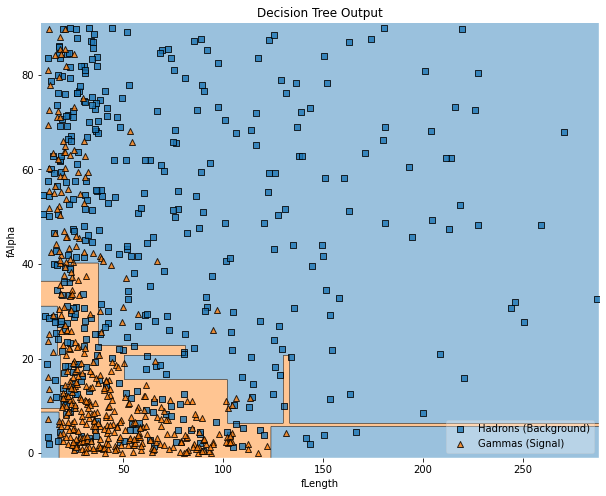

In [ ]:
#----------------------
# Plot Decision Tree 
#----------------------
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=tree_clf_2var, legend=2)
plt.title('Decision Tree Output')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Hadrons (Background)', 'Gammas (Signal)'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


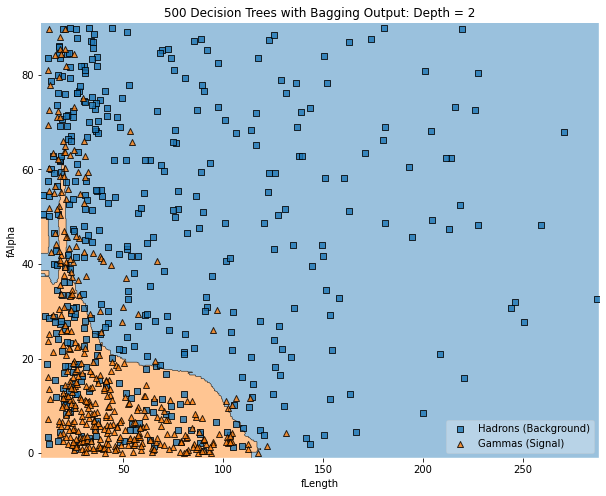

In [ ]:
#----------------------
# Plot Bagging Tree 
#----------------------
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=bag_clf_2var, legend=2)
plt.title('500 Decision Trees with Bagging Output: Depth = 2')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Hadrons (Background)', 'Gammas (Signal)'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


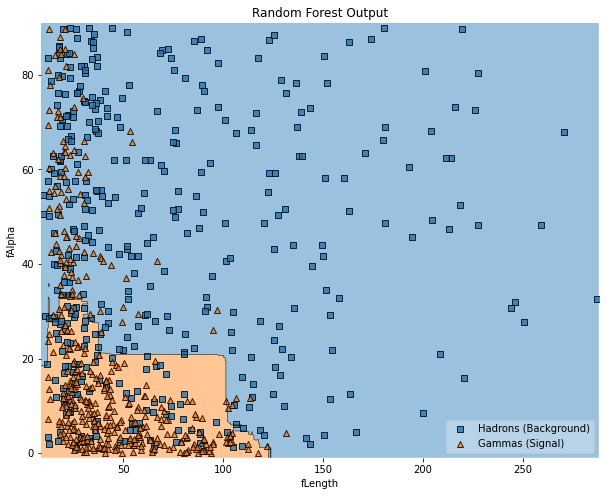

In [ ]:
#----------------------
# Plot Random Forest
#----------------------
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=rf_clf_2var, legend=2)
plt.title('Random Forest Output')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Hadrons (Background)', 'Gammas (Signal)'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


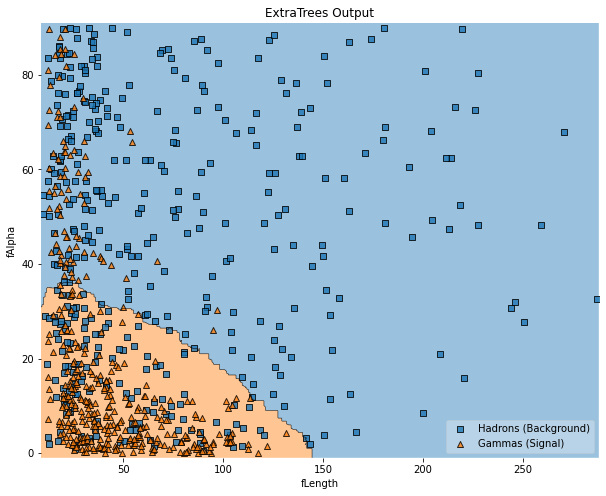

In [ ]:
#----------------------
# Plot ExtraTrees
#----------------------
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=ext_clf_2var, legend=2)
plt.title('ExtraTrees Output')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Hadrons (Background)', 'Gammas (Signal)'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


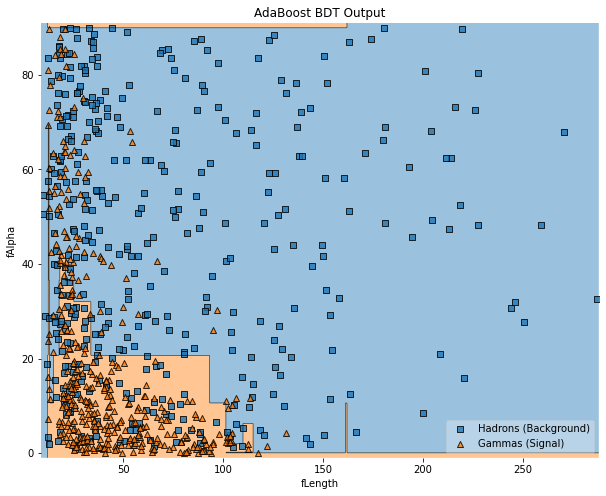

In [ ]:
#----------------------
# Plot AdaBoost BDT
#----------------------
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=ada_clf_2var, legend=2)
plt.title('AdaBoost BDT Output')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Hadrons (Background)', 'Gammas (Signal)'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


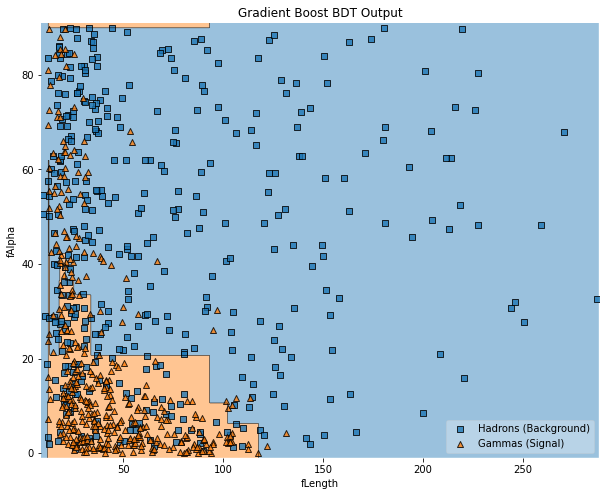

In [ ]:
#----------------------
# Plot Gradient Boost BDT
#----------------------
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=grad_clf_2var, legend=2)
plt.title('Gradient Boost BDT Output')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Hadrons (Background)', 'Gammas (Signal)'], 
           framealpha=0.3, scatterpoints=1)
plt.show()

In [ ]:
# Get the ROC Curves
fpr_2var_1, tpr_2var_1, thresholds = metrics.roc_curve(y_test.astype(bool), tree_clf_2var_proba)
fpr_2var_2, tpr_2var_2, thresholds = metrics.roc_curve(y_test.astype(bool), bag_clf_2var_proba)
fpr_2var_3, tpr_2var_3, thresholds = metrics.roc_curve(y_test.astype(bool), rf_clf_2var_proba)
fpr_2var_4, tpr_2var_4, thresholds = metrics.roc_curve(y_test.astype(bool), ada_clf_2var_proba)
fpr_2var_5, tpr_2var_5, thresholds = metrics.roc_curve(y_test.astype(bool), grad_clf_2var_proba)
fpr_2var_6, tpr_2var_6, thresholds = metrics.roc_curve(y_test.astype(bool), ext_clf_2var_proba)


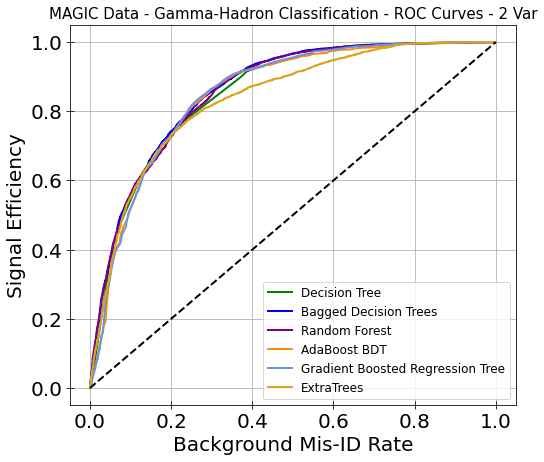

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.plot(fpr_2var_1, tpr_2var_1, linewidth=2, color='green',label="Decision Tree")
ax.plot(fpr_2var_2, tpr_2var_2, linewidth=2, color='blue',label="Bagged Decision Trees")
ax.plot(fpr_2var_3, tpr_2var_3, linewidth=2, color='purple',label="Random Forest")
ax.plot(fpr_2var_4, tpr_2var_4, linewidth=2, color='darkorange',label="AdaBoost BDT")
ax.plot(fpr_2var_5, tpr_2var_5, linewidth=2, color='cornflowerblue',label="Gradient Boosted Regression Tree")
ax.plot(fpr_2var_6, tpr_2var_6, linewidth=2, color='goldenrod',label="ExtraTrees")

ax.set_ylabel("Signal Efficiency" ,  fontsize=20)
ax.set_xlabel("Background Mis-ID Rate" , fontsize=20)
ax.set_title('MAGIC Data - Gamma-Hadron Classification - ROC Curves - 2 Var' , fontsize=15)

ax.tick_params(axis='both', which='major', length=8, labelsize=20,  direction = "inout")

# Draw a grid
ax.grid(True,which='major', axis='both')

# Draw a line to represent breaking even (no classification advantage)
x = [0,1]
y = [0,1]
ax.plot(x, y,linestyle='dashed', linewidth=2, color = "Black")

# Draw a legend
plt.legend(loc='lower right', prop={'size': 12})

fig.show()

## Example 2: Train and test multiple ensemble classifiers using all 10 features found in the MAGIC dataset

In [ ]:
df_all_train_drop = df_all_train.drop(columns=['class', 'isGamma', 'isHadron'])
df_all_test_drop = df_all_test.drop(columns=['class', 'isGamma', 'isHadron'])
df_all_test_small_drop = df_all_test_small.drop(columns=['class', 'isGamma', 'isHadron'])

In [ ]:
# Create a 2D numpy array from this dataframe
X_train_10var = df_all_train_drop.values
X_test_10var = df_all_test_drop.values
X_test_small_10var = df_all_test_drop.values

# Create a 1D numpy array containing the "truth" information 
y_train = df_all_train["isGamma"].cat.codes.values
y_test = df_all_test["isGamma"].cat.codes.values
y_test_small = df_all_test_small["isGamma"].cat.codes.values

In [ ]:
#-------------------------------------
# Decision tree 
#-------------------------------------

# Create the classifier (clf)
tree_clf_10var = DecisionTreeClassifier(max_depth=5)

# Build the classifiers using the training dataset and truth information
tree_clf_10var.fit(X_train_fLength_fAlpha, y_train)

# Get the predictions for your test dataset
tree_clf_10var_pred = tree_clf_10var.predict(X_test_fLength_fAlpha)

# Get the prediction probabilities from your test dataset
#   (the fraction of samples in each leaf)
tree_clf_10var_proba = tree_clf_10var.predict_proba(X_test_fLength_fAlpha)[:,1]


In [ ]:
#-------------------------------------
# Bagging classifier  
#-------------------------------------

# Create the classifier (clf)
bag_clf_10var = BaggingClassifier( 
    DecisionTreeClassifier(max_depth=5),
    n_estimators=100, # Number of trees 
    max_samples=100, # Number of subsets of the training data
    bootstrap=True, # True = with replacement = bagging, False = no replacement = Pasting
    n_jobs=-1 # USe all CPU cores
) 

# Train 
bag_clf_10var.fit(X_train_10var, y_train)

# Get the predicions
bag_clf_10var_pred = bag_clf_10var.predict(X_test_10var)

# Get the prediction probabilities
bag_clf_10var_proba = bag_clf_10var.predict_proba(X_test_10var)[:,1]

In [ ]:
#-------------------------------------
# Random Forest classifier  
#-------------------------------------

# Create the classifier (clf)
rf_clf_10var = RandomForestClassifier( 
    max_depth=5,
    n_estimators=500, # Number of trees in the forest
    n_jobs=-1 # USe all CPU cores
) 

# Train 
rf_clf_10var.fit(X_train_10var, y_train)

# Get the predicions
rf_clf_10var_pred = rf_clf_10var.predict(X_test_10var)

# Get the prediction probabilities
rf_clf_10var_proba = rf_clf_10var.predict_proba(X_test_10var)[:,1]

In [ ]:
#-------------------------------------
# Extremely Randomized Trees classifier  
#-------------------------------------

# Create the classifier (clf)
ext_clf_10var = ExtraTreesClassifier( 
    max_depth=5,
    n_estimators=500, # Number of trees in the forest
    min_samples_split=2
  ) 

# Train 
ext_clf_10var.fit(X_train_10var, y_train)

# Get the predicions
ext_clf_10var_pred = ext_clf_10var.predict(X_test_10var)

# Get the prediction probabilities
ext_clf_10var_proba = ext_clf_10var.predict_proba(X_test_10var)[:,1]

In [ ]:
#-------------------------------------
# BDT classifier using AdaBoost
#-------------------------------------

# Create the classifier (clf)
ada_clf_10var = AdaBoostClassifier( 
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100, # Number of iterations 
    algorithm="SAMME.R",
    learning_rate=0.5
) 

# Train the BDT
ada_clf_10var.fit(X_train_10var, y_train)

# Get the BDT predicions
ada_clf_10var_pred = ada_clf_10var.predict(X_test_10var)

# Get the BDT prediction probabilities
ada_clf_10var_proba = ada_clf_10var.predict_proba(X_test_10var)[:,1]

In [ ]:
#-------------------------------------
# BDT classifier using Gradient Boosting
#-------------------------------------

grad_clf_10var = GradientBoostingClassifier( 
    max_depth=1,
    n_estimators=40, # Number of iterations 
    learning_rate=0.5
) 

# Train the BDT
grad_clf_10var.fit(X_train_fLength_fAlpha, y_train)

# Get the BDT predicions
grad_clf_10var_pred = grad_clf_10var.predict(X_test_fLength_fAlpha)

# Get the BDT prediction probabilities
grad_clf_10var_proba = grad_clf_10var.predict_proba(X_test_fLength_fAlpha)[:,1]

Again borrow some code from project 1 to create a ROC curve using only fAlpha. This will serve as a comparision (we can compare the decision tree to a simple 1D cut).


In [ ]:
def make_ROC_arrays(my_feature_name, ge, low, high, verbose ):
  
  cuts = np.linspace(low,high,101)
  le_cut =  9999999
  ge_cut = -9999999
  # Create lists to contain the number of events passing a given cut
  effic  = []
  mistag = []
  list_cuts = []
  
  for cut in cuts:

    if ge:
      ge_cut = cut
      le_cut = high
    else:
      ge_cut = low
      le_cut = cut

    s_num = df_gammas[ (df_gammas[my_feature_name]>= ge_cut) & (df_gammas[my_feature_name]<= le_cut)][my_feature_name].count()
    s_den = df_gammas[my_feature_name].count()
    s_eff = s_num/s_den

    b_num = df_hadrons[ (df_hadrons[my_feature_name]>= ge_cut) & (df_hadrons[my_feature_name]<= le_cut)][my_feature_name].count()
    b_den = df_hadrons[my_feature_name].count()
    b_eff = b_num/b_den

    effic.append(s_eff)
    mistag.append(b_eff)
    list_cuts.append(cut)

    if(verbose):
       print(ge_cut,"<= ",my_feature_name," <=", le_cut, "s_eff",s_eff,"b_eff",b_eff)

  a_effic  = np.array(effic)
  a_mistag = np.array(mistag)
  a_cuts = np.array(list_cuts)

  return a_effic, a_mistag, a_cuts

In [ ]:
# Get the 1D ROC curve
a_eff_s_fAlpha   , a_eff_b_fAlpha, a_cuts_fAlpha   = make_ROC_arrays("fAlpha"   , False, 0,100, False)

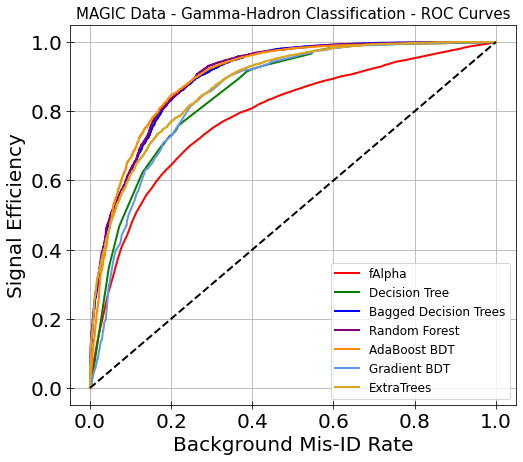

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Get the ROC curves from scikitlearn
fpr1, tpr1, thresholds = metrics.roc_curve(y_test.astype(bool), tree_clf_10var_proba)
fpr2, tpr2, thresholds = metrics.roc_curve(y_test.astype(bool), bag_clf_10var_proba)
fpr3, tpr3, thresholds = metrics.roc_curve(y_test.astype(bool), rf_clf_10var_proba)
fpr4, tpr4, thresholds = metrics.roc_curve(y_test.astype(bool), ada_clf_10var_proba)
fpr5, tpr5, thresholds = metrics.roc_curve(y_test.astype(bool), grad_clf_10var_proba)
fpr6, tpr6, thresholds = metrics.roc_curve(y_test.astype(bool), ext_clf_10var_proba)

# Plot the ROC curves
ax.plot(a_eff_b_fAlpha   , a_eff_s_fAlpha   , "-", linewidth=2, label='fAlpha',  color='Red') 
ax.plot(fpr1, tpr1, linewidth=2, color='green',label="Decision Tree")
ax.plot(fpr2, tpr2, linewidth=2, color='blue',label="Bagged Decision Trees")
ax.plot(fpr3, tpr3, linewidth=2, color='purple',label="Random Forest")
ax.plot(fpr4, tpr4, linewidth=2, color='darkorange',label="AdaBoost BDT")
ax.plot(fpr5, tpr5, linewidth=2, color='cornflowerblue',label="Gradient BDT")
ax.plot(fpr6, tpr6, linewidth=2, color='goldenrod',label="ExtraTrees")

# Label plot
ax.set_ylabel("Signal Efficiency" ,  fontsize=20)
ax.set_xlabel("Background Mis-ID Rate" , fontsize=20)
ax.set_title('MAGIC Data - Gamma-Hadron Classification - ROC Curves' , fontsize=15)

# Draw a grid
ax.grid(True,which='major', axis='both')
ax.tick_params(axis='both', which='major', length=8, labelsize=20,  direction = "inout")

# Draw a line to represent breaking even (no classification advantage)
x = [0,1]
y = [0,1]
ax.plot(x, y,linestyle='dashed', linewidth=2, color = "Black")

# Draw a legend
plt.legend(loc='lower right', prop={'size': 12})

fig.show()

## Example 3 - Error rate vs Number of BDT iterations

In lecture 2 we defined "Accuracy" = "Number of correct labels" / "Total number of events" 

We can also define "Error Rate" = "Number of incorrect labels" / "Total number of events" 

The relationship between these is as follows:

Error Rate = 1 – Accuracy

We can use the sklearn tool accuracy_score to calculate the accuracy. The staged_predict member of sklearn.ensemble.AdaBoostClassifier allows us to view the prediction for each iteration of the BDT. The code below shows an example of calculating the error rate at each stage.

Text(0.5, 0, 'Tree iteration')

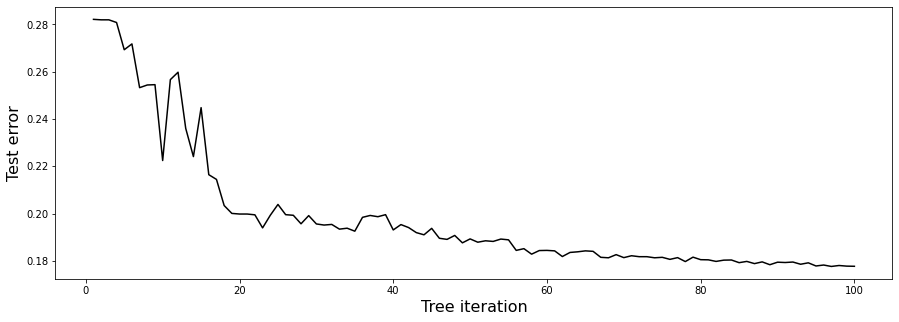

In [ ]:
from sklearn.metrics import accuracy_score

test_errors = []
for test_predict in ada_clf_10var.staged_predict(X_test_10var):
    test_errors.append(1.0 - accuracy_score(test_predict, y_test))

plt.figure(figsize=(15, 5))
plt.plot(range(1, len(ada_clf_10var) + 1), test_errors,"-k")
plt.ylabel("Test error" ,  fontsize=16)
plt.xlabel("Tree iteration" , fontsize=16)

## Part 1: Grow your own tree

Pick your two favorite variables from Project 1. Use these two variables to train your own ensemble tools. Basically your goal is to repeat Example 1 from above but with different variables. Using your two features, train a decision tree, a bagging classifier, a random forrest, and an AdaBoost BDT. Plot the decision regions for each classifier. You are free to experiment with the algorithm parameters if you wish.


## Part 2: Measure feature performance

In Example 2 we trained a 10 feature random forest. Some features may have more discrimination power than others and may have played a larger role in achieving the ensemble performance. Follow the instructions found in the link below to measure the relative importance of each feature. Do the performances you measure match your expectations from what you learned in Project 1?

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

(Note: Try both methods discussed in the link)

## Part 3: AdaBoost Parameters

Train four 10 feature BDTs using AdaBoost (see Example 2) and the following parameters.

1. n_estimators=50, learning_rate=1.0
2. n_estimators=50, learning_rate=0.1
3. n_estimators=200, learning_rate=1.0
4. n_estimators=200, learning_rate=0.1

Make the following plots:
1. Compare the ROC curve for each BDT on one plot. 
2. Compare the error rate as a function of the number of iterations (Example 3) for each BDT on one plot. 